In [4]:
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt

In [5]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("../") ; sys.path.append("../../") 
from ppe_analysis.analysis import *

In [6]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300641', # Input your project ID here
    walltime='03:00:00', # Amount of wall time
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45497 instead
  warnings.warn(


### validating pbmean in the fullgrid

In [7]:
def amean(da,cf=1/365):
    #annual mean
    m  = da['time.daysinmonth']
    xa = cf*(m*da).groupby('time.year').sum().compute()
    xa.name=da.name
    return xa


In [8]:
# calculate average TBOT and PREC from the h0 tapes
# PREC=RAIN+SNOW
# use the last 30 years
d='/glade/campaign/cgd/tss/people/oleson/PPE/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
files=sorted(glob.glob(d+'*h0*'))[-360:]

tmp=xr.open_dataset(files[0])
lah0=tmp.area*tmp.landfrac

def preprocess(ds):
    dvs=['TBOT','RAIN','SNOW']
    return ds[dvs]

ds=xr.open_mfdataset(files,combine='nested',concat_dim='time',parallel=True,
                     preprocess=preprocess,decode_times=False)
ds['time']=xr.cftime_range('1985',periods=360,freq='MS',calendar='noleap')

In [9]:
cf=24*60*60*365/10
tbot=amean(ds.TBOT).mean(dim='year')-273.15  #degC
rain=cf*amean(ds.RAIN).mean(dim='year')   #cm/yr
snow=cf*amean(ds.SNOW).mean(dim='year')   #cm/yr
prec=rain+snow

In [10]:
### Readin 'h1' tape
def preprocess(ds):
    dvs=['TLAI','GPP','pfts1d_wtgcell']
    return ds[dvs]

d='/glade/campaign/cgd/tss/people/oleson/PPE/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
files=sorted(glob.glob(d+'*h1*'))[-360:]

ds_h1=xr.open_mfdataset(files,combine='nested',concat_dim='time',parallel=True,
                        preprocess=preprocess)
ds_h1['time']=xr.cftime_range('1985',periods=360,freq='MS',calendar='noleap')

In [11]:
# pfts1d_ixy and pfts1d_jxy will be useful, 
# but make sure to subtract 1 for pythonic indexing
# I think these change in time (but we aren't taking that into account)
#   DK: no, they do not change, pfts1d_wtgcell is the only one that varies in time
tmp=xr.open_dataset(files[0])
lon_id = (tmp.pfts1d_ixy-1).astype('int')
lat_id = (tmp.pfts1d_jxy-1).astype('int')

In [12]:
# paste those climatologies into h1-shaped vectors
ta_h1 = xr.DataArray([tbot.isel(lat=j, lon=i) for i, j in zip(lon_id, lat_id)],
                     dims='pft')
pr_h1 = xr.DataArray([prec.isel(lat=j, lon=i) for i, j in zip(lon_id, lat_id)],
                     dims='pft')

In [13]:
# also calculate the GPP climatology (directly from h1)
# I use this for differentiating icesheets from tundra biome
gpp_clim_h1 = amean(ds_h1.GPP).mean(dim='year').compute()

### assign biome

In [14]:
def byhand(t,p):
    t1 = -5  #    tundra-boreal
    t2 =  3  #    boreal-temperate
    t3 = 20  # temperate-tropical

    tvals = [-np.inf,t1,t2,t3,np.inf]
    bvals = [9,8,4,1]


    for i in range(4):
        if (t>tvals[i])&(t<=tvals[i+1]):
            b = bvals[i]

    td = 15; pd=60; bd=3  #desert
    if (t>td)&(p<pd):
        b = bd

    return b

In [15]:
import joblib
import geopandas as gpd
from shapely.geometry import *

In [16]:
fp = './whit/Whittaker_biomes.shp'
data = gpd.read_file(fp)
newb = np.array([9,8,7,6,5,4,1,2,3])
data.biome_id=newb #more logical order

In [17]:
def get_bclass(n):
    npft=len(ta_h1)
    pp=[i for i in range(n*1000,min(npft,(n+1)*1000))]
    bclass=np.zeros(len(pp))+np.nan
    for i in range(len(pp)):
        p=pp[i]
        if (ta_h1[p]<0)&(gpp_clim_h1[p]==0):
            bclass[i]=0  #ice
        else:
            ptf = gpd.GeoDataFrame({'geometry':[Point(ta_h1[p],pr_h1[p])]})
            x=gpd.overlay(ptf, data, how='intersection')
            if len(x)>0:
                bclass[i] = x.biome_id.values[0]
            else:
                bclass[i] = byhand(ta_h1[p],pr_h1[p])
    return bclass
    

In [18]:
with joblib.parallel_config(backend="dask"):
    results=joblib.Parallel(verbose=1)(joblib.delayed(get_bclass)(i) for i in range(119))

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:   32.6s finished


In [19]:
bclass=np.concatenate(results)

In [20]:
# create the pxb vector
# pxb= pfts1d_itype_veg*10 + biome_id
pxb = tmp.pfts1d_itype_veg*10+bclass
pxb.name='pxb'

In [21]:
# create the appropriate landarea vector
la = xr.DataArray([lah0.isel(lat=j, lon=i) for i, j in zip(lon_id, lat_id)],
                  dims='pft')
lah1 = la * ds_h1.pfts1d_wtgcell
pft_la = lah1.mean(dim='time')

In [22]:
da = amean(ds_h1.TLAI)

In [31]:
laann=lah1.groupby('time.year').mean().compute()

In [28]:
lapb=laann.groupby(pxb).sum().compute()

In [33]:
# finally we can do a pxbmean via:
lai_pxb_fg = (1/lapb*(laann*da).groupby(pxb).sum()).compute()

In [39]:
dsout=xr.Dataset()
dsout['area']=lapb
dsout['lai_pxb_fg']=lai_pxb_fg
dsout.to_netcdf('/glade/work/djk2120/ppe_savs/pbmean/lai_pxb_fg.nc')

### computing pbmean for the same simulation subset to the sparsegrid 

In [42]:
# read in random sparsegrid file
f = '/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC0000.clm2.h1.2005-02-01-00000.nc'
sg = xr.open_dataset(f)

In [43]:
# read in random fullgrid file
d = '/glade/campaign/cgd/tss/people/oleson/PPE/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
f = 'clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist.clm2.h1.2014-12.nc'
fg = xr.open_dataset(d+f)

In [44]:
# create the map from fg -> sg
ixp=sg.pfts1d_itype_veg>0
fgks=[]
k=np.arange(len(fg.pft))
for p,i,j in zip(sg.pfts1d_itype_veg[ixp],
                 sg.pfts1d_ixy[ixp],
                 sg.pfts1d_jxy[ixp]):
    ix=(fg.pfts1d_itype_veg==p)&(fg.pfts1d_ixy==i)&(fg.pfts1d_jxy==j)
    fgks.append(k[ix])
fgmap=np.zeros(len(sg.pft)).astype(int)
fgmap[ixp]=np.array(fgks).ravel()

In [45]:
# read in biome vector and pft vector
whit=xr.open_dataset('whit/whitkey.nc')
f='/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC0000.clm2.h1.2005-02-01-00000.nc'
ds=xr.open_dataset(f)
pft=ds.pfts1d_itype_veg
# define the pft-x-biome group
pftbiome=xr.DataArray(np.zeros(ds.pft.shape)+np.nan,dims='pft',name='pxb')
for i in range(1,17):
    pftbiome[pft==i]=whit.biome.values+10*i

In [46]:
laisg=xr.DataArray(ds_h1.TLAI.isel(pft=fgmap).values,dims=['time','pft'])
lapft=xr.open_dataset('landarea_transient.nc').landarea_pft

In [47]:
lapb=lapft.groupby(pftbiome).sum().compute()
lai_pb_sg=amean(1/lapb.where(lapb>0)*(lapft.values*laisg).groupby(pftbiome).sum().compute())

In [49]:
dsout=xr.Dataset()
dsout['area']=amean(lapb)
dsout['lai_pxb_sg']=lai_pb_sg

In [51]:
dsout.to_netcdf('/glade/work/djk2120/ppe_savs/pbmean/lai_pxb_sg.nc')

### examining the results

In [53]:
ds1=xr.open_dataset('/glade/work/djk2120/ppe_savs/pbmean/lai_pxb_fg.nc')
ds2=xr.open_dataset('/glade/work/djk2120/ppe_savs/pbmean/lai_pxb_sg.nc')
whit=xr.open_dataset('whit/whitkey.nc')

In [152]:
bigs=ds1.area.mean(dim='year').argsort()[-15:]
pbs=np.flipud([ds1.pxb[big].values for big in bigs])
pbs=pbs[pbs>9]  #exclude PFT0 - not_vegetated

12

In [87]:
p=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/LHC0000.nc')
pftnames=[str(p)[2:-1].strip() for p in p.pftname[:17].values]

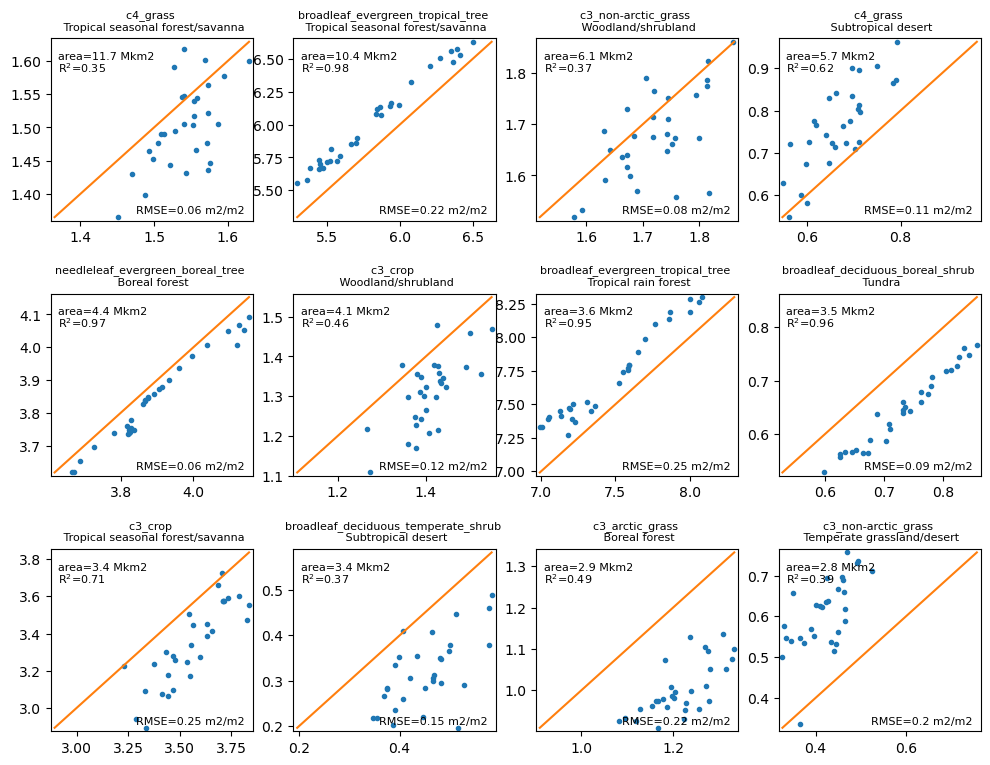

In [154]:
plt.figure(figsize=[12,9])
for i,pb in enumerate(pbs):
    plt.subplot(3,4,i+1)

    pft=int(pb/10)  #PFT is the first one or two digits
    b=pb-10*pft     #biome is the last digit
    
    x=ds1.lai_pxb_fg.sel(pxb=pb)
    y=ds2.lai_pxb_sg.sel(pxb=pb)
    a=np.round(ds1.area.sel(pxb=pb).mean(dim='year').values/1e6,1)
    r2=np.round(np.corrcoef(x,y)[0,1]**2,2)
    rmse=np.round(np.sqrt(np.mean((x-y)**2).values),2)

    minn=np.min([x,y])
    maxx=np.max([x,y])
    delt=maxx-minn
    
    plt.plot(x,y,'.')
    plt.title(pftnames[pft]+' \n '+
              str(whit.biome_name.sel(biome_id=b).values),fontsize=8);
    plt.xlim([minn-0.02*delt,maxx+0.02*delt])
    plt.ylim([minn-0.02*delt,maxx+0.02*delt])
    plt.plot([minn,maxx],[minn,maxx]);
    plt.text(minn+0.02*delt,minn+0.9*delt,'area='+str(a)+' Mkm2',fontsize=8)
    plt.text(minn+0.02*delt,minn+0.825*delt,'R$^2$='+str(r2),fontsize=8)
    plt.text(minn+0.98*delt,minn+0.02*delt,'RMSE='+str(rmse)+' m2/m2',fontsize=8,ha='right');

plt.subplots_adjust(hspace=0.4)
plt.savefig('pxb_validation.png',dpi=300,bbox_inches='tight')

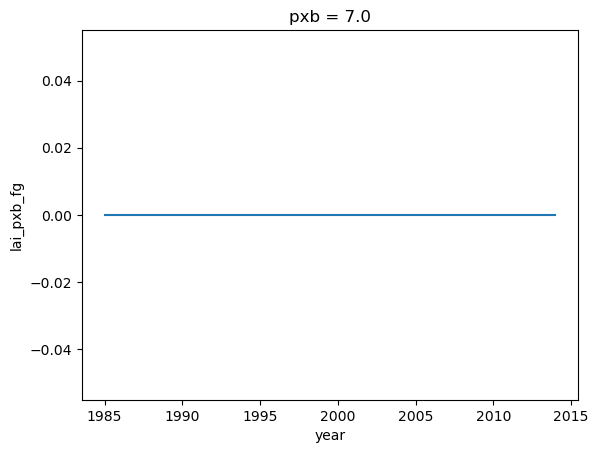

In [67]:
ds1.lai_pxb_fg.sel(pxb=7).plot()

### pbmean function for the sparsegrid

In [175]:
# read in biome vector and pft vector
whit=xr.open_dataset('whit/whitkey.nc')
f='/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC0000.clm2.h1.2005-02-01-00000.nc'
ds=xr.open_dataset(f)
pft=ds.pfts1d_itype_veg
# define the pft-x-biome group
pftbiome=xr.DataArray(np.zeros(ds.pft.shape)+np.nan,dims='pft',name='pb')
for i in range(1,17):
    pftbiome[pft==i]=whit.biome.values+10*i

def pbmean(da,a,minarea=5e4):
    asum=a.groupby(pftbiome).sum()
    asum=asum.where(asum>minarea)
    dapb=1/asum*(a*da).groupby(pftbiome).sum().compute()
    #append useful labels
    pb=dapb.pb
    dapb['pft']  =np.floor(pb/10).astype(int)
    dapb['biome']=(pb-10*dapb.pft).astype(int)
    return dapb

In [177]:
pftbiome.pft

<xarray.DataArray 'pft' (pft: 8574)>
array([   0,    1,    2, ..., 8571, 8572, 8573])
Dimensions without coordinates: pft

### testing function

In [58]:
#read in dummy data
f='/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC0000.clm2.h1.2005-02-01-00000.nc'
ds=xr.open_dataset(f)
ds['time']=xr.cftime_range('2005',periods=120,freq='MS',calendar='noleap')
lapft=xr.open_dataset('landarea_transient.nc').landarea_pft

In [63]:
#note that lapft has a time dimension in the transient cases
#your area vector must comply with your data array in the time dimension
#e.g., if you use annualized lai, you must annualize lapft
lai=ds.TLAI.groupby('time.year').mean().compute()
a=lapft.groupby('time.year').mean()
dapb=pbmean(lai,a)

In [64]:
p=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/LHC0000.nc')
pftnames=[str(p.pftname[i].values)[2:-1].strip() for i in range(17)]

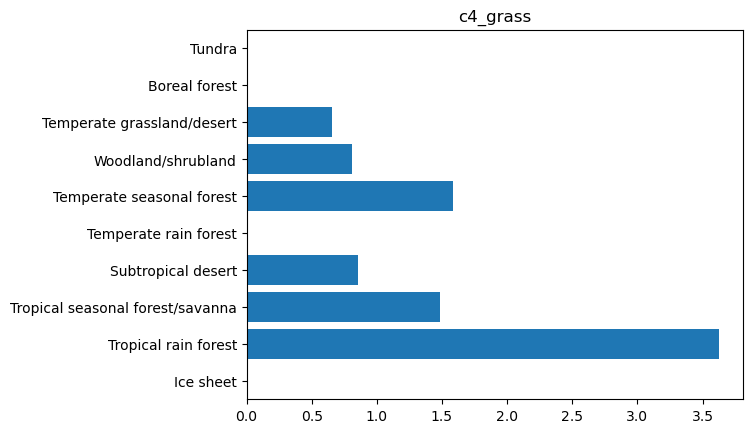

In [65]:
pft=14
plt.barh(range(10),dapb.mean(dim='year').isel(pb=dapb.pft==pft))
plt.yticks(range(10),whit.biome_name.values)
plt.ylim([-0.5,9.5]);
plt.title(pftnames[pft]);